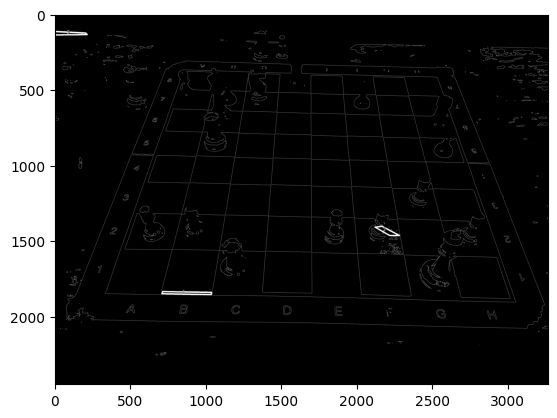

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 


image = cv2.imread(r"/home/dev303/Pictures/Screenshots/chessboard.jpeg") # opencv reads images as BGR format

gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.imshow(rgb_image) # matplotlib expects RGB format 
gaussian_blur = cv2.GaussianBlur(gray_image,(5,5),0)
plt.imshow(gaussian_blur,cmap="gray")
ret,otsu_binary = cv2.threshold(gaussian_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(otsu_binary,cmap="gray")
canny = cv2.Canny(otsu_binary,20,255)

plt.imshow(canny,cmap="gray")
kernel = np.ones((7, 7), np.uint8) 
  
img_dilation = cv2.dilate(canny, kernel, iterations=1) 

plt.imshow(img_dilation,cmap="gray")
lines = cv2.HoughLinesP(img_dilation, 1, np.pi/180, threshold=200, minLineLength=100, maxLineGap=50)

if lines is not None:
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        
        # draw lines
        cv2.line(img_dilation, (x1, y1), (x2, y2), (255,255,255), 2)

plt.imshow(img_dilation,cmap="gray")
kernel = np.ones((3, 3), np.uint8) 
  
img_dilation_2 = cv2.dilate(img_dilation, kernel, iterations=1) 

plt.imshow(img_dilation_2,cmap="gray")

# find contours --> img_dilation_2
board_contours, hierarchy = cv2.findContours(img_dilation_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

square_centers=list()

# draw filtered rectangles to "canny" image for better visualization
board_squared = canny.copy()  

for contour in board_contours:
    if 4000 < cv2.contourArea(contour) < 20000:
        # Approximate the contour to a simpler shape
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Ensure the approximated contour has 4 points (quadrilateral)
        if len(approx) == 4:
            pts = [pt[0] for pt in approx]  # Extract coordinates

            # Define the points explicitly
            pt1 = tuple(pts[0])
            pt2 = tuple(pts[1])
            pt4 = tuple(pts[2])
            pt3 = tuple(pts[3])

            x, y, w, h = cv2.boundingRect(contour)
            center_x=(x+(x+w))/2
            center_y=(y+(y+h))/2

            square_centers.append([center_x,center_y,pt2,pt1,pt3,pt4])

             

            # Draw the lines between the points
            cv2.line(board_squared, pt1, pt2, (255, 255, 0), 7)
            cv2.line(board_squared, pt1, pt3, (255, 255, 0), 7)
            cv2.line(board_squared, pt2, pt4, (255, 255, 0), 7)
            cv2.line(board_squared, pt3, pt4, (255, 255, 0), 7)


plt.imshow(board_squared,cmap="gray")
sorted_coordinates = sorted(square_centers, key=lambda x: x[1], reverse=True)

groups = []
current_group = [sorted_coordinates[0]]

for coord in sorted_coordinates[1:]:
    if abs(coord[1] - current_group[-1][1]) < 50:
        current_group.append(coord)
    else:
        groups.append(current_group)
        current_group = [coord]

# Append the last group
groups.append(current_group)

# Step 2: Sort each group by the second index (column values)
for group in groups:
    group.sort(key=lambda x: x[0])

# Step 3: Combine the groups back together
sorted_coordinates = [coord for group in groups for coord in group]

sorted_coordinates[:10]
for num in range(len(sorted_coordinates)-1):
    if abs(sorted_coordinates[num][1] - sorted_coordinates[num+1][1])< 50 :
        if sorted_coordinates[num+1][0] - sorted_coordinates[num][0] > 150:
            x=(sorted_coordinates[num+1][0] + sorted_coordinates[num][0])/2
            y=(sorted_coordinates[num+1][1] + sorted_coordinates[num][1])/2
            p1=sorted_coordinates[num+1][5]
            p2=sorted_coordinates[num+1][4]
            p3=sorted_coordinates[num][3]
            p4=sorted_coordinates[num][2]
            sorted_coordinates.insert(num+1,[x,y,p1,p2,p3,p4])
square_num=1
for cor in sorted_coordinates:
  cv2.putText(img = board_squared,text = str(square_num),org = (int(cor[0])-30, int(cor[1])),
    fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 1,color = (125, 246, 55),thickness = 3)
  square_num+=1

plt.imshow(board_squared,cmap="gray")
